In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import warnings
import pandas as pd 
import numpy as np 

warnings.simplefilter(action="ignore", category=FutureWarning)

Data Parameterization

want vector of theta vectors per individual/scenario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/MIT/Classes/6.882/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MIT/Classes/6.882


In [ ]:
df = pd.read_csv('chn8.csv')
temp = df.groupby('UserID').count().reset_index().reset_index()[['index','UserID']]
df = df.merge(temp, how='left', on='UserID')
df

,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,...,MaleDoctor,Dog,Cat,Review_age,Review_education,Review_gender,Review_income,Review_political,Review_religious,index
0,299AB2iHwJt8bD7j3,686739463_9556284339632838.0,9.556284e+15,3,0,1,0,1,Old,Age,...,0.0,0.0,0.0,18.0,college,female,under5000,0.65,0.50,7
1,6SRHpLrBhraFNRmCd,-1662891142_9556284339632838.0,9.556284e+15,12,0,0,0,1,Pets,Species,...,0.0,3.0,1.0,18.0,college,female,under5000,0.65,0.50,7
2,6pcMLzW4To94ZiiPz,-1662891142_9556284339632838.0,9.556284e+15,5,0,1,0,2,Less,Utilitarian,...,0.0,0.0,0.0,18.0,college,female,under5000,0.65,0.50,7
3,6yKWAprYtrA7sZj7F,-1662891142_9556284339632838.0,9.556284e+15,2,0,0,0,2,Fit,Fitness,...,0.0,0.0,0.0,18.0,college,female,under5000,0.65,0.50,7
4,7ojXYpSfFGhHvvca5,-1662891142_9556284339632838.0,9.556284e+15,10,0,0,0,2,High,Social Status,...,0.0,0.0,0.0,18.0,college,female,under5000,0.65,0.50,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,tkSt5hSu5DehXnyYC,-1318233634_7907457820719717.0,7.907458e+15,10,0,1,0,0,Fat,Fitness,...,0.0,0.0,0.0,42.0,graduate,male,50000,0.50,0.01,3
375,y3zZB4DYhpJ39yw2K,-1318233634_7907457820719717.0,7.907458e+15,6,0,0,1,0,Female,Gender,...,0.0,0.0,0.0,42.0,graduate,male,50000,0.50,0.01,3
376,q66gzYqkyYq7JkZL6,-1318233634_7907457820719717.0,7.907458e+15,4,1,0,1,0,Young,Age,...,0.0,0.0,0.0,42.0,graduate,male,50000,0.50,0.01,3
377,tkSt5hSu5DehXnyYC,-1318233634_7907457820719717.0,7.907458e+15,10,1,1,0,0,Fit,Fitness,...,0.0,0.0,0.0,42.0,graduate,male,50000,0.50,0.01,3


In [ ]:
# df[df['Intervention_x']==0]
df.columns

Index(['ResponseID_x', 'ExtendedSessionID_x', 'UserID', 'ScenarioOrder_x',
       'Intervention_x', 'PedPed_x', 'Barrier_x', 'CrossingSignal_x',
       'AttributeLevel_x', 'ScenarioTypeStrict_x', 'ScenarioType_x',
       'DefaultChoice_x', 'NonDefaultChoice_x', 'DefaultChoiceIsOmission_x',
       'NumberOfCharacters_x', 'DiffNumberOFCharacters_x', 'Saved_x',
       'Template_x', 'DescriptionShown_x', 'LeftHand_x', 'UserCountry3_x',
       'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy',
       'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal',
       'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete',
       'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'ResponseID_y',
       'ExtendedSessionID_y', 'ScenarioOrder_y', 'Intervention_y', 'PedPed_y',
       'Barrier_y', 'CrossingSignal_y', 'AttributeLevel_y',
       'ScenarioTypeStrict_y', 'ScenarioType_y', 'DefaultChoice_y',
       'NonDefaultChoice_y', 'DefaultChoiceIsOmission_y',
       'NumberOf

In [ ]:
test_idx = [11,12,13]
test_data = df[df['ScenarioOrder'].isin(test_idx)]

In [ ]:
pd.set_option('display.max_columns', 500)

In [ ]:
'''
Splitting training and testing thetas
training - first 10 scenarios per respondent
testing - last 3 scenarios
'''

train_theta0_list = []
train_theta1_list = []
train_observed = []
train_respondents_idx = []

for name, group in df.groupby(['UserID','ResponseID']):
  if group.shape[0]==2:
    # print(group)
 
    row0 = group[group['Intervention']==1] # 0: character will die if AV stays, thus if no intervention, characters saved are when intervention=1
    row1 = group[group['Intervention']==0] # 1: character will die if AV swerves
    # print(row0)
    # print('break')
    # print(row1)
    if row0['ScenarioOrder'].iloc[0] not in test_idx:
      chosen_outcome = 1 if row1['Saved'].iloc[0]==1 else 0   # 0: user decided to kill characters in this outcome, 1: saved characters
      train_observed.append(chosen_outcome)
      
      train_theta0 = [0, row0['Man'].iloc[0], row0['Woman'].iloc[0], row0['Boy'].iloc[0], 
              row0['Girl'].iloc[0], row0['OldMan'].iloc[0], row0['OldWoman'].iloc[0], row0['Stroller'].iloc[0],
              row0['Pregnant'].iloc[0], row0['LargeMan'].iloc[0], row0['LargeWoman'].iloc[0], row0['MaleAthlete'].iloc[0],
              row0['FemaleAthlete'].iloc[0], row0['MaleExecutive'].iloc[0], row0['FemaleExecutive'].iloc[0], row0['MaleDoctor'].iloc[0],
              row0['FemaleDoctor'].iloc[0], row0['Homeless'].iloc[0], row0['Criminal'].iloc[0], row0['Dog'].iloc[0], row0['Cat'].iloc[0]
              ] 

      train_theta0_list.append(np.array(train_theta0))

      train_theta1 = [1, row1['Man'].iloc[0], row1['Woman'].iloc[0], row1['Boy'].iloc[0], 
              row1['Girl'].iloc[0], row1['OldMan'].iloc[0], row1['OldWoman'].iloc[0], row1['Stroller'].iloc[0],
              row1['Pregnant'].iloc[0], row1['LargeMan'].iloc[0], row1['LargeWoman'].iloc[0], row1['MaleAthlete'].iloc[0],
              row1['FemaleAthlete'].iloc[0], row1['MaleExecutive'].iloc[0], row1['FemaleExecutive'].iloc[0], row1['MaleDoctor'].iloc[0],
              row1['FemaleDoctor'].iloc[0], row1['Homeless'].iloc[0], row1['Criminal'].iloc[0], row1['Dog'].iloc[0], row1['Cat'].iloc[0]
              ] 
      train_theta1_list.append(np.array(train_theta1))
      
      
      train_respondents_idx.append(row0['index'].iloc[0])

train_observed = np.array(train_observed)


In [ ]:
sum(train_observed) / len(train_observed)

0.4028776978417266

In [ ]:
# Initialize A (15x21) binary matrix of moral values corresponding to characters
A_list = [
     [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], #Intervene
     [0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0], #Male
     [0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0], #Female
     [0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0], #Young
     [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], #Old
     [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0], #Infancy
     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0], #Pregnancy
     [0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0], #Fat
     [0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0], #Fit
     [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0], #Working
     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0], #Medical
     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0], #Homeless
     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0], #Criminal
     [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0], #Human
     [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1], #Non-Human
     ]
A = np.array(A_list)

In [ ]:
# Feature Mapping F: Theta -> Lambda by F(Theta) = A*Theta
# where lambda_y is abstract feature space

train_lambda_y0 = []
for theta0 in train_theta0_list:
    train_lambda_y0.append(A @ theta0)

train_lambda_y1 = []
for theta1 in train_theta1_list: 
    train_lambda_y1.append(A @ theta1)

In [ ]:
train_lambda_y0 = np.array([np.array(i) for i in train_lambda_y0])
train_lambda_y1 = np.array([np.array(i) for i in train_lambda_y1])

In [ ]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.11.4
Running on ArviZ v0.12.0


model creation

In [ ]:
# setting some params from data

respondents_idx = [int(x) for x in train_respondents_idx]

n = 8 # number of respondents, might be different
d = 15  # number of moral principles
print(n, d)

8 15


In [ ]:
with pm.Model() as model:
    # (1) CALCULATE COVARIANCE MATRIX SIGMA_G
    sd_dist = pm.Exponential.dist(1.0)

    chol, _, _ = pm.LKJCholeskyCov("chol", n=d, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
   
    # (2) CALCULATE GROUP PRIORS 
    group_priors = pm.MvNormal('group_priors', mu=np.zeros(d), chol=cov, shape=(1,d))    
    
    #(3) CALCAUTE INDIVIDUAL PRIORS 
    priors = pm.MvNormal('priors', mu=group_priors, chol=cov, shape=(n,d))

    #(4) CALCULATE UTILITY
    utility = pm.Deterministic('utility', (train_lambda_y1*priors[respondents_idx]).sum(axis=1) - 
                                          (train_lambda_y0*priors[respondents_idx]).sum(axis=1))
                                  
    p = 1 / (1 + np.exp(-1 * utility))

    y_obs = pm.Bernoulli('y_obs', p=p, observed=train_observed) 


sample from posterior distribution created above

In [ ]:
with model: 
  trace = pm.sample(draws=1000, chains=2, cores=4, target_accept=0.90)

pm.save_trace(trace, "trace_chn_8_15mv_1000draw_1000tune.trace")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [priors, group_priors, chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1773 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


'trace_chn_8_15mv_1000draw_1000tune.trace'

In [ ]:
with model:
   trace = pm.load_trace('trace_chn_4_15mv_1000draw_1000tune.trace') 

trace1 = trace['cov']
trace2 = trace['group_priors']
trace3 = trace['priors']
print("chol shape: ", trace1.shape)
print("group_priors shape: ", trace2.shape)
print("group_priors mean: ", np.mean(trace2, axis=0))
print("priors shape: ", trace3.shape)
print("priors element example: ", trace3[0][0])

chol shape:  (2000, 15, 15)
group_priors shape:  (2000, 1, 15)
group_priors mean:  [[-0.02967214 -0.03387043  0.75237774 -0.26985355  0.14837314  0.5495377
  -0.06990852  0.04375039 -0.02580053 -1.26693844  1.95605215 -0.47631051
   0.93791159  0.12518389 -0.45434939]]
priors shape:  (2000, 4, 15)
priors element example:  [ 0.16252135  0.00572954 -0.41965619 -1.00869343 -0.0615241   0.93560874
  0.6184891   0.52113736 -0.01213185 -0.65333342  1.94040729  0.06209337
  0.58122036 -0.17629094 -1.11570227]


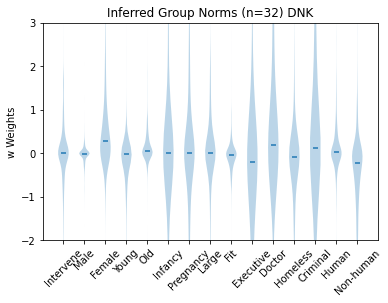

In [ ]:
moral_values = ['Intervene', 'Male', 'Female', 'Young', 'Old', 'Infancy', 'Pregnancy', 'Large', 'Fit',
                'Executive', 'Doctor', 'Homeless', 'Criminal', 'Human', 'Non-human'] 

gp = pd.DataFrame(trace['group_priors'].reshape(2000, 15)) #(2000,1,15))
gp.columns = moral_values
#print(gp.describe())

data_to_plot = [gp['Intervene'], gp['Male'], gp['Female'], 
                gp['Young'], gp['Old'], gp['Infancy'], gp['Pregnancy'],
                gp['Large'], gp['Fit'], 
                gp['Executive'], gp['Doctor'],
                gp['Homeless'], gp['Criminal'] , gp['Human'], gp['Non-human']
                ]

fig, ax = plt.subplots() 

bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=True, showextrema=False)
ax.set_title('Inferred Group Norms (n=32) ALL')
ax.set_ylabel('w Weights')

ax.set_xticks(range(1,16))
ax.set_xticklabels(moral_values, rotation=45, fontsize=10)
ax.set_ylim([-2,3])

plt.show()

In [ ]:
cov_matrix = pd.DataFrame(np.mean(trace['cov'], axis=0))
cov_matrix.columns = moral_values
cov_matrix.index = moral_values
print(cov_matrix.shape)
# print(cov_matrix.describe())

(15, 15)


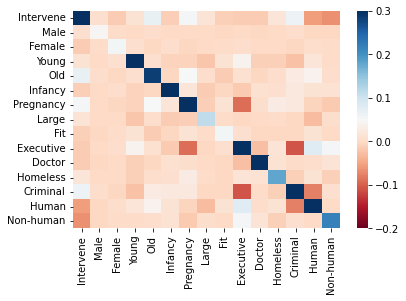

In [ ]:
ax = sns.heatmap(cov_matrix, cmap="RdBu", vmin=-0.2, vmax=.3)

In [ ]:
# get mean individual priors to evaluate accuracy
# shape of priors: (2000, n, d)
priors_mean = np.mean(trace['priors'], axis=0)
print("expected shape: (n,d), actual shape: ", priors_mean.shape)

expected shape: (n,d), actual shape:  (4, 15)


In [ ]:
def predict_outcome(weights, lambda0, lambda1):
    utility = np.dot(weights, lambda1) - np.dot(weights, lambda0)
    if utility < 0:
        return 0
    else:
        return 1

def get_accuracy(test_data):
    total = 0
    results = []

    for name, group in test_data.groupby(['UserID','ResponseID']):
      if group.shape[0]==2:
        row0 = group[group['Intervention']==1]
        row1 = group[group['Intervention']==0]

        chosen_outcome = 1 if row1['Saved'].iloc[0]==1 else 0
        
        user_num = row0['index'].iloc[0]
        
        theta0 = [0, row0['Man'].iloc[0], row0['Woman'].iloc[0], row0['Boy'].iloc[0], 
              row0['Girl'].iloc[0], row0['OldMan'].iloc[0], row0['OldWoman'].iloc[0], 
              row0['Stroller'].iloc[0], row0['Pregnant'].iloc[0], row0['LargeMan'].iloc[0], row0['LargeWoman'].iloc[0], 
              row0['MaleAthlete'].iloc[0], row0['FemaleAthlete'].iloc[0], row0['MaleExecutive'].iloc[0], row0['FemaleExecutive'].iloc[0], 
              row0['MaleDoctor'].iloc[0], row0['FemaleDoctor'].iloc[0], row0['Homeless'].iloc[0], row0['Criminal'].iloc[0], 
              row0['Dog'].iloc[0], row0['Cat'].iloc[0]
              ] 
        
        theta1 = [1, row1['Man'].iloc[0], row1['Woman'].iloc[0], row1['Boy'].iloc[0], 
              row1['Girl'].iloc[0], row1['OldMan'].iloc[0], row1['OldWoman'].iloc[0], 
              row1['Stroller'].iloc[0], row1['Pregnant'].iloc[0], row1['LargeMan'].iloc[0], row1['LargeWoman'].iloc[0], 
              row1['MaleAthlete'].iloc[0], row1['FemaleAthlete'].iloc[0], row1['MaleExecutive'].iloc[0], row1['FemaleExecutive'].iloc[0], 
              row1['MaleDoctor'].iloc[0], row1['FemaleDoctor'].iloc[0], row1['Homeless'].iloc[0], row1['Criminal'].iloc[0], 
              row1['Dog'].iloc[0], row1['Cat'].iloc[0]
              ] 
        
        lambda0 = A @ theta0
        lambda1 = A @ theta1

        weights = priors_mean[user_num] 
        predicted = predict_outcome(weights, lambda0, lambda1)

        results.append([chosen_outcome, predicted, row0['Review_gender'].iloc[0], row0['Review_education'].iloc[0], row0['Review_income'].iloc[0]])
    return pd.DataFrame(results) 


In [ ]:
acc = get_accuracy(df) #test_data
acc.columns = ['chosen', 'predicted', 'gender', 'education', 'income']
print("overall accuracy: ", acc[acc['chosen']==acc['predicted']].shape[0]/acc.shape[0])
print(acc['income'].unique())

overall accuracy:  0.8846153846153846
['above100000' 'under5000' '25000']


In [ ]:
accuracy_female = acc[(acc['chosen']==acc['predicted']) & (acc['gender']=='female')].shape[0] / acc[acc['gender']=='female'].shape[0]
accuracy_male = acc[(acc['chosen']==acc['predicted']) & (acc['gender']=='male')].shape[0] / acc[acc['gender']=='male'].shape[0]
accuracy_default = acc[(acc['chosen']==acc['predicted']) & (acc['gender']=='default')].shape[0] / acc[acc['gender']=='default'].shape[0]
# accuracy_others = acc[(acc['chosen']==acc['predicted']) & (acc['gender']=='others')].shape[0] / acc[acc['gender']=='others'].shape[0]

print(accuracy_female, accuracy_male, accuracy_default)

0.7855822550831792 0.7956989247311828 0.7410714285714286


In [ ]:
high = acc[(acc['chosen']==acc['predicted']) & (acc['education']=='high')].shape[0] / acc[acc['education']=='high'].shape[0]
bachelor = acc[(acc['chosen']==acc['predicted']) & (acc['education']=='bachelor')].shape[0] / acc[acc['education']=='bachelor'].shape[0]
college = acc[(acc['chosen']==acc['predicted']) & (acc['education']=='college')].shape[0] / acc[acc['education']=='college'].shape[0]
graduate = acc[(acc['chosen']==acc['predicted']) & (acc['education']=='graduate')].shape[0] / acc[acc['education']=='graduate'].shape[0]
underHigh = acc[(acc['chosen']==acc['predicted']) & (acc['education']=='underHigh')].shape[0] / acc[acc['education']=='underHigh'].shape[0]

print(high, bachelor, college, graduate, underHigh)

0.7875457875457875 0.8262295081967214 0.8067632850241546 0.8042895442359249 0.7676767676767676


In [ ]:
under5000 = acc[(acc['chosen']==acc['predicted']) & (acc['income']=='under5000')].shape[0] / acc[acc['income']=='under5000'].shape[0]
ten_000 = acc[(acc['chosen']==acc['predicted']) & (acc['income']=='10000')].shape[0] / acc[acc['income']=='10000'].shape[0]
above100000 = acc[(acc['chosen']==acc['predicted']) & (acc['income']=='above100000')].shape[0] / acc[acc['income']=='above100000'].shape[0]

print(under5000, ten_000, above100000)

0.7866379310344828 0.7967479674796748 0.7582938388625592
